In [1]:
import sys
!{sys.executable} -m pip install chess

import os.path
import itertools
import numpy as np
import scipy.ndimage as ndi
from skimage import io, color, filters, feature, segmentation, measure, draw, exposure, transform
from sklearn import cluster # scikit-learn: a machine learning library
import matplotlib as mpl
import matplotlib.pylab as plt
import cv2

import math
import chess


In [2]:
plt.gray();
mpl.rcParams['figure.figsize'] = (10,10)

<Figure size 432x288 with 0 Axes>

In [3]:
if os.path.isdir('ImageProcessingF2021'):
    !git -C ImageProcessingF2021 pull
else:
    !git clone https://github.com/MoravianCollege/ImageProcessingF2021.git

Already up to date.


In [4]:
# FEN starts from rank 8 and ends at rank 1
# A number in FEN represents number of empty spaces

RANK_DELIMITER = '/'

WHITE_KING = 'K'
WHITE_QUEEN = 'Q'
WHITE_BISHOP = 'B'
WHITE_KNIGHT = 'N'
WHITE_ROOK = 'R'
WHITE_PAWN = 'P'

BLACK_KING = 'k'
BLACK_QUEEN = 'q'
BLACK_BISHOP = 'b'
BLACK_KNIGHT = 'n'
BLACK_ROOK = 'r'
BLACK_PAWN = 'p'

WHITES_TURN = 'w'
BLACKS_TURN = 'b'

WHITE_KINGSIDE_CASTLES = 'K'
WHITE_QUEENSIDE_CASTLES = 'Q'
BLACK_KINGSIDE_CASTLES = 'k'
BLACK_QUEENSIDE_CASTLES = 'q'
NO_CASTLES = '-'

# If there is an en passant then target square is recorded
NO_ENPASSANT = '-'

# The number of halfmoves since the last capture or pawn advance, used for the fifty-move rule
DEFAULT_HALF_MOVES = 0

# The number of the full move. It starts at 1, and is incremented after Black's move.
DEFAULT_HALF_MOVES = 1


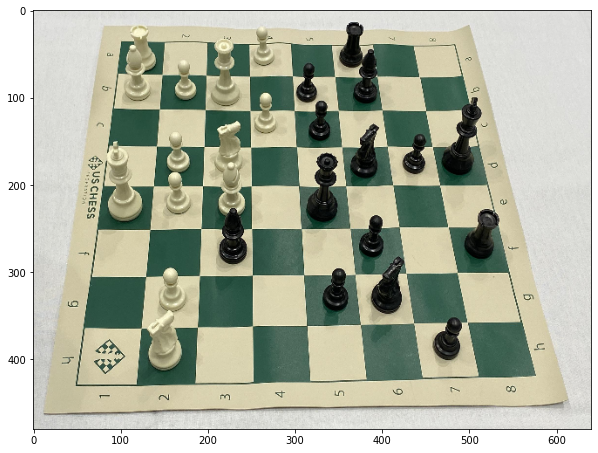

In [218]:
VIDEO_SHAPE = (640, 480)

im_board = io.imread('chess_board_images/chess_position_1.jpg')
im_board = cv2.resize(im_board, VIDEO_SHAPE)

plt.imshow(im_board)

In [208]:
EDGE_DETECTION_THRESHOLD = 0.05
GAUSSIAN_BLUR_SIGMA = 0.7

In [131]:
def process_chessboard_im(im):
    gray = color.rgb2gray(im) # convert to grayscale
    blurred = ndi.gaussian_filter(gray, GAUSSIAN_BLUR_SIGMA) # blur
    # plt.imshow(blurred)
    edges = filters.sobel(blurred) # detect edges
    thresh = edges > EDGE_DETECTION_THRESHOLD # threshold

    return thresh

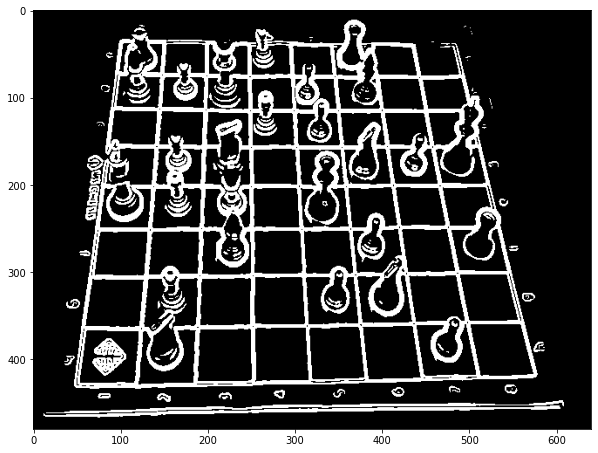

In [219]:
im_processed = process_chessboard_im(im_board)
plt.imshow(im_processed)

In [32]:
def angle_to_slope(angle):
    return np.tan(angle + (np.pi/2))

def angles_dists_to_points(angles, dists):
    x_coords = dists * np.cos(angles)
    y_coords = dists * np.sin(angles)

    return x_coords, y_coords

def angles_dists_to_points_slopes(angles, dists):
    x_coords = dists * np.cos(angles)
    y_coords = dists * np.sin(angles)
    
    slopes = [angle_to_slope(a) for a in angles]

    return x_coords, y_coords, slopes

In [99]:
HOUGH_LINES_DISPLAY_WIDTH = 4

In [91]:
def plot_lines_hough(im, angles, dists, points=[], line_color='red', point_color='blue'):
    """
    Plots an image (im) and then draws the lines as given by the angles (in radians)
    and distances from (0,0).
    Optionally draws a list of points given by (points).
    """
    x_coords, y_coords = angles_dists_to_points(angles, dists)

    plt.imshow(im)

    # Force the limits on the axes
    h, w = im.shape
    plt.xlim((0, w))
    plt.ylim((h, 0))

    # Plot the lines
    for x, y, angle in zip(x_coords, y_coords, angles):
        # plt.plot(x, y, color='green', marker='o', linestyle='dashed', linewidth=2, markersize=12)
        plt.axline((x, y), slope=angle_to_slope(angle), color=line_color, linewidth=HOUGH_LINES_DISPLAY_WIDTH)

    # Plot the points
    for x, y in points:
        plt.plot(x, y, color=point_color, marker='o', linestyle='dashed', linewidth=2, markersize=12)

In [41]:
def draw_lines_hough(im, angles, dists, points=[]):
    """
    Draws the lines given by the angles (in radians)
    and distances from (0,0) on a copy of im and returns the copy.
    Optionally draws a list of points given by (points).
    """
    im = (color.gray2rgb(im) * 255).round().astype('uint8')

    x_coords, y_coords = angles_dists_to_points(angles, dists)

    # Draw the lines
    for x, y, angle in zip(x_coords, y_coords, angles):
        slope = angle_to_slope(angle)
        # TODO: Use OpenCV to draw lines

    # Plot the points
    for x, y in points:
        # TODO: Not Working
        cv2.circle(im, (int(x), int(y)), 5, (0, 0, 255), -1)
    
    return im

In [43]:
def hough_lines(im):
    hspace, angles, dists = transform.hough_line(im)
    peak_vals, angles, dists = transform.hough_line_peaks(hspace, angles, dists)
    return angles, dists

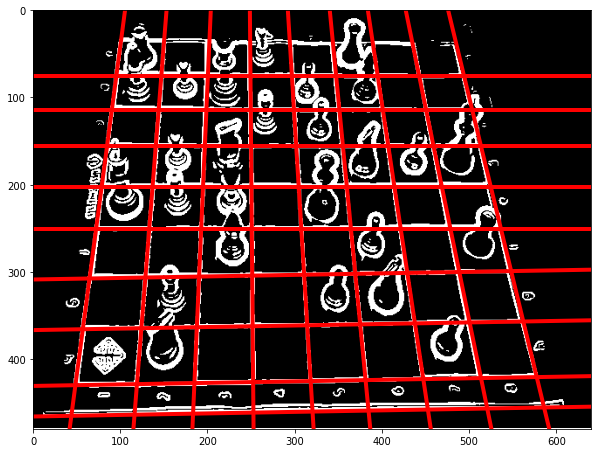

In [220]:
angles, dists = hough_lines(im_processed)
plot_lines_hough(im_processed, angles, dists)

In [69]:
def swap_lesser(a, b):
    if (a < b):
        return a, b
    else:
        return b, a

def index_top_two_max(arr):
    indices, _ = zip(*sorted(enumerate(arr), key=lambda x: x[1]))
    return indices[-2:]

'''
Clusters lines into two groups.
'''
def split_lines(angles, dists):
    assert len(angles) == len(dists)

    if len(angles) < 2:
        return ([], []), ([], [])

    # Sort lines
    lines = zip(angles, dists)
    lines = sorted(lines, key=lambda l: l[0])

    # get gradient of angles
    angle_gradients = []
    for i in range(len(lines)):
        angle_1 = lines[i][0]
        angle_2 = lines[(i+1) % len(lines)][0]
        angle_gradients.append(abs(angle_1 - angle_2))

    # get the indices of the top two peaks in the gradient
    i1_max, i2_max = index_top_two_max(angle_gradients)
    assert i1_max != i2_max
    i1_max, i2_max = swap_lesser(i1_max, i2_max)

    # extract clusters from peaks
    lines_1 = lines[i1_max+1:i2_max+1]
    lines_2 = lines[i2_max+1:] + lines[:i1_max+1]

    return zip(zip(*lines_1), zip(*lines_2))

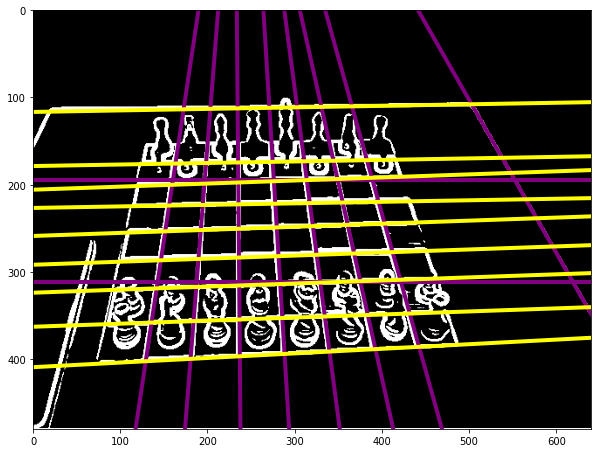

In [216]:
angle_clusters, dist_clusters = split_lines(angles, dists)

plot_lines_hough(im_processed, angle_clusters[1], dist_clusters[1], line_color='purple')
plot_lines_hough(im_processed, angle_clusters[0], dist_clusters[0], line_color='yellow')

In [15]:
def find_y_intercept(x, y, slope):
    return y - (slope * x)

In [23]:
def solve_linear_equation(m1, b1, m2, b2):
    a = (m1 - m2)
    x = 0 if a == 0 else (b2 - b1) / a
    y = (m1 * x) + b1
    return x, y

In [24]:
def find_intersections(angles_1, dists_1, angles_2, dists_2):
    assert len(angles_1) == len(dists_1)
    assert len(angles_2) == len(dists_2)

    x_coords_1, y_coords_1, slopes_1 = angles_dists_to_points_slopes(angles_1, dists_1)
    x_coords_2, y_coords_2, slopes_2 = angles_dists_to_points_slopes(angles_2, dists_2)

    intercepts_1 = [find_y_intercept(x, y, s) for x, y, s in zip(x_coords_1, y_coords_1, slopes_1)]
    intercepts_2 = [find_y_intercept(x, y, s) for x, y, s in zip(x_coords_2, y_coords_2, slopes_2)]

    intersections = []

    for m1, b1 in zip(slopes_1, intercepts_1):
        for m2, b2 in zip(slopes_2, intercepts_2):
            intersections.append(solve_linear_equation(m1, b1, m2, b2))

    return intersections

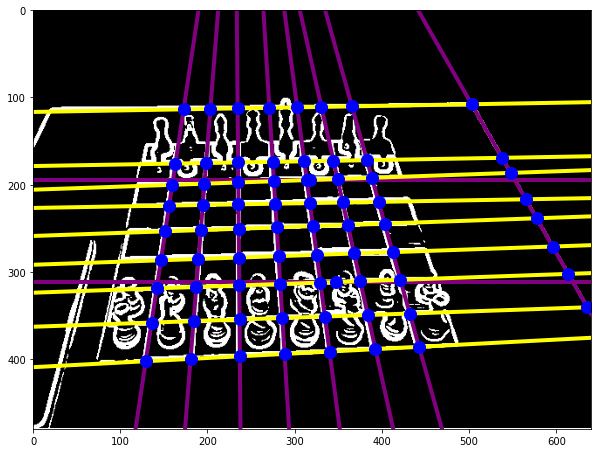

In [217]:
intersections = find_intersections(angle_clusters[0], dist_clusters[0], angle_clusters[1], dist_clusters[1])

plot_lines_hough(im_processed, angle_clusters[1], dist_clusters[1], line_color='purple')
plot_lines_hough(im_processed, angle_clusters[0], dist_clusters[0], points=intersections, line_color='yellow')

In [19]:
from ImageProcessingF2021.video import run_video

In [22]:
def find_chess_board(im):
    # process image
    im_processed = process_chessboard_im(im)

    # get lines
    angles, dists = hough_lines(im_processed)

    # cluster lines into 2 groups
    angle_clusters, dist_clusters = split_lines(angles, dists)
    
    # find intersections between lines from both clusters
    intersections = find_intersections(angles[0], dists[0], angles[1], dists[1])

    return im_processed

# run_video(find_chess_board, camera_num=0)